In [148]:
# Import required libraries
import requests
import re
from bs4 import BeautifulSoup
import datetime as dt
import pandas as pd

# Database connector 
import mysql.connector
from mysql.connector import Error

In [149]:
# Connect to the database
connection = mysql.connector.connect(
    host = 'localhost',
    port = 3306,
    user = 'root',
    password = '#',
    database = 'arsenaldb'
)

# Function to execute a SQL query 
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Successful")
    except Error as err:
        print(f"Error: '{err}'")

# Read and Run Query
def read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall() # Reads data from the database without making any changes to it.
        return result
    except Error as err:
        print(f'Error: "{err}"')

## Create Database Table - Transfers

In [162]:
# Drop Table
execute_query(connection, """ 
DROP TABLE IF EXISTS transfers
""")

# Create Table
transfers_table = """
CREATE TABLE transfers(
    TransferID INT NOT NULL PRIMARY KEY UNIQUE KEY AUTO_INCREMENT,
    PlayerName VARCHAR(80) NOT NULL,
    Position VARCHAR(80) NOT NULL,
    Age VARCHAR(10),
    Transfer_Type_Amount VARCHAR(40),
    TransferStatus ENUM('In','Out') NOT NULL,
    Club VARCHAR(80) NOT NULL,
    League VARCHAR(80) NOT NULL,
    SeasonName VARCHAR(80)
)
"""
execute_query(connection, transfers_table)


Successful
Successful


In [163]:
# Assign the seasons accordingly
season_mapping = {
    2023:'2023-2024',
    2022:'2022-2023',
    2021:'2021-2022',
    2020:'2020-2021',
    2019:'2019-2020'
}

# DEPARTURES

def departure(season):

    # Scrape the data using BeautifulSoup
    headers = {
    "User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    }

    url = f'https://www.transfermarkt.com/arsenal-fc/transfers/verein/11/plus/?saison_id={season}&pos=&detailpos=&w_s='
    response = requests.get(url, headers=headers)

    soup = BeautifulSoup(response.content, "html.parser")

    # Departure HTML classes
    odd_dept = soup.select('div[id="yw2"] tr[class="odd"]')
    even_dept = soup.select('div[id="yw2"] tr[class="even"]')

    # Data Cleaning
    # Departures 1/2
    c_list = []
    for i in range(len(odd_dept)):
        c_list.append(odd_dept[i].text.split('\n'))

    odd_dept_list = []
    for i in c_list:
        n_sublist = [value.strip() for value in i if value.strip()]
        odd_dept_list.append(n_sublist)

    # Departures 2/2
    d_list = []
    for i in range(len(even_dept)):
        d_list.append(even_dept[i].text.split('\n'))

    even_dept_list = []
    for i in d_list:
        n_sublist = [value.strip() for value in i if value.strip()]
        even_dept_list.append(n_sublist)

    # Join both lists together into a single one
    dept_list = odd_dept_list + even_dept_list

    # Convert the list into a dataframe
    df_departures = pd.DataFrame(dept_list)

    # Rename the columns
    df_departures.rename(columns = {0:'Player',
                                1:'Position',
                                2:'Age',
                                3:'Club',
                                4:'League',
                                5:'Transfer_Type_Amount'},
                                inplace= True)
    
    # Create new columns to the dataframe
    df_departures['Status'] = 'Out'
    df_departures['SeasonName'] = season_mapping[season]
    
    return df_departures


# ARRIVALS
def arrivals(season):

    # Scrape the data
    headers = {
    "User-Agent" : "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
    }

    url = f'https://www.transfermarkt.com/arsenal-fc/transfers/verein/11/plus/?saison_id={season}&pos=&detailpos=&w_s='
    response = requests.get(url, headers=headers)

    soup = BeautifulSoup(response.content, "html.parser")

    # Arrival HTML classes
    odd_arrive = soup.select('div[id="yw1"] tr[class="odd"]')
    even_arrive = soup.select('div[id="yw1"] tr[class="even"]')

    # Arrivals 1/2
    a_list = []
    for i in range(len(odd_arrive)):
        a_list.append(odd_arrive[i].text.split('\n'))

    odd_arrive_list = []
    for i in a_list:
        n_sublist = [value.strip() for value in i if value.strip()]
        odd_arrive_list.append(n_sublist)

    # Arrivals 2/2
    b_list = []
    for i in range(len(even_arrive)):
        b_list.append(even_arrive[i].text.split('\n'))

    even_arrive_list = []
    for i in b_list:
        n_sublist = [value.strip() for value in i if value.strip()]
        even_arrive_list.append(n_sublist)

    # Join the lists
    arrival_list = odd_arrive_list + even_arrive_list

    # Convert the list into a dataframe
    df_arrivals = pd.DataFrame(arrival_list)
    df_arrivals.rename(columns = {0:'Player',
                                1:'Position',
                                2:'Age',
                                3:'Club',
                                4:'League',
                                5:'Transfer_Type_Amount'},
                                inplace= True)
    df_arrivals['Status'] = 'In'
    df_arrivals['SeasonName'] = season_mapping[season]
    
    return df_arrivals

In [164]:
# Function to join all transfers
def transfers(departure, arrival):

    df_transfers = pd.concat([departure, arrival], axis = 0, ignore_index=True) 
    
    return df_transfers

In [165]:
# Get transfers
df_transfers_19 = transfers(departure(2019), arrivals(2019))
df_transfers_20 = transfers(departure(2020), arrivals(2020))
df_transfers_21 = transfers(departure(2021), arrivals(2021))
df_transfers_22 = transfers(departure(2022), arrivals(2022))
df_transfers_23 = transfers(departure(2023), arrivals(2023))

In [166]:
season_transfers = [df_transfers_19,df_transfers_20,df_transfers_21,df_transfers_22, df_transfers_23]
df_transfers_table = pd.concat(season_transfers, ignore_index=True)
df_transfers_table = df_transfers_table.loc[:,['Player','Position','Age','Transfer_Type_Amount',
                                               'Status','Club','League','SeasonName']]
df_transfers_table.rename(columns= {'Player':'PlayerName', 'Status':'TransferStatus'}, inplace=True)
df_transfers_table.head()

,PlayerName,Position,Age,Transfer_Type_Amount,TransferStatus,Club,League,SeasonName
0,Alex Iwobi,Attacking Midfield,23,€30.40m,Out,Everton,Premier League,2019-2020
1,Laurent Koscielny,Centre-Back,33,€5.00m,Out,G. Bordeaux,Ligue 1,2019-2020
2,Henrikh Mkhitaryan,Central Midfield,30,Loan fee:€3.10m,Out,AS Roma,Serie A,2019-2020
3,Takuma Asano,Right Winger,24,€1.00m,Out,Partizan,Super liga Srbije,2019-2020
4,Aaron Ramsey,Central Midfield,28,free transfer,Out,Juventus,Serie A,2019-2020


In [167]:
# Convert to a dictionary
dict_transfers = df_transfers_table.to_dict(orient='index')

sql_command = []

for i in range(len(dict_transfers)):
    columns = ", ".join(dict_transfers[i].keys())

    # Store each value in double quotes
    values = ", ".join(f'"{value}"' for value in dict_transfers[i].values())

    sql_query = f'INSERT INTO transfers ({columns}) VALUES ({values})'
    sql_command.append(sql_query)

sql_command[5]

'INSERT INTO transfers (PlayerName, Position, Age, Transfer_Type_Amount, TransferStatus, Club, League, SeasonName) VALUES ("Stephan Lichtsteiner", "Right-Back", "35", "free transfer", "Out", "FC Augsburg", "Bundesliga", "2019-2020")'

In [ ]:
# Execute the query to insert data into the table
for query in sql_command:
    try:
        execute_query(connection, query)
    except Error as err:
        print(f"Error: '{err}'")

In [170]:
# Run Query
run_table = """SELECT * 
FROM transfers;"""
results = read_query(connection, run_table)

# View as dataframe
# Convert to pandas dataframe
league_columns = ['TransferID','PlayerName','Position','Age','Transfer_Type_Amount',
                  'TransferStatus','Club','League','SeasonName']
df_table = pd.DataFrame(results, columns = league_columns)
df_table.head()

,TransferID,PlayerName,Position,Age,Transfer_Type_Amount,TransferStatus,Club,League,SeasonName
0,1,Alex Iwobi,Attacking Midfield,23,€30.40m,Out,Everton,Premier League,2019-2020
1,2,Laurent Koscielny,Centre-Back,33,€5.00m,Out,G. Bordeaux,Ligue 1,2019-2020
2,3,Henrikh Mkhitaryan,Central Midfield,30,Loan fee:€3.10m,Out,AS Roma,Serie A,2019-2020
3,4,Takuma Asano,Right Winger,24,€1.00m,Out,Partizan,Super liga Srbije,2019-2020
4,5,Aaron Ramsey,Central Midfield,28,free transfer,Out,Juventus,Serie A,2019-2020


<Axes: >

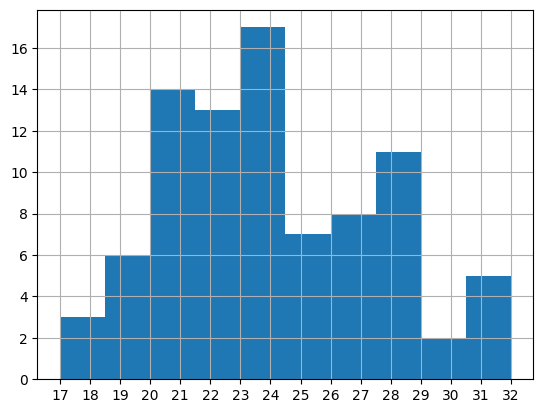

In [173]:
transfer_in = df_table[df_table['TransferStatus'] == 'In']
transfer_in['Age'].sort_values().hist()

## Position Table

In [70]:
# Assign the seasons accordingly
season_mapping = {
    2023:'2023-2024',
    2022:'2022-2023',
    2021:'2021-2022',
    2020:'2020-2021',
    2019:'2019-2020'
}

# Define a function that takes a season, scrapes the data and stores in 'df_wages' variable accordingly

def position(season):

    page_url = f'https://fbref.com/en/squads/18bb7c10/{season}/wages/Arsenal-Wage-Details'

    df_position = pd.read_html(page_url, attrs = {'id':"wages"})[0]
    
    # # Filter for neeeded data
    df_position = df_position.loc[:,['Player','Pos']]

    # # Rename Column
    df_position.rename(columns = {'Player' :'PlayerName',
                                    'Pos' : 'Position'}, inplace=True)

    # # Drop the last row
    df_position.drop(df_position.tail(1).index, inplace=True)

    # Add season name
    df_position['SeasonName'] = season
    

    return df_position


In [76]:
# Enter desired season
df_position_19 = position(season_mapping[2019])
df_position_20 = position(season_mapping[2020])
df_position_21 = position(season_mapping[2021])
df_position_22 = position(season_mapping[2022])
df_position_23 = position(season_mapping[2023])


In [80]:
dfs_to_concat = [df_position_19, df_position_20, df_position_21, df_position_22, df_position_23]
df_positions_table = pd.concat(dfs_to_concat, ignore_index=True)

# Data cleaning - Drop duplicates
df_positions_table = df_positions_table.drop_duplicates(ignore_index=True)
df_positions_table.sample(5)

,PlayerName,Position,SeasonName
53,Rúnar Alex Rúnarsson,GK,2020-2021
11,Shkodran Mustafi,DF,2019-2020
31,Willian,FW,2020-2021
15,Dani Ceballos,MF,2019-2020
67,Aaron Ramsdale,GK,2021-2022
